<a href="https://colab.research.google.com/github/joblazek/psp-auction/blob/main/Algorithm1_async.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import threading
import time
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, Tuple, List, Optional
from mpl_toolkits.mplot3d import Axes3D

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

np.random.seed(12345)
np.set_printoptions(precision=4)

class Seller:
    """Holds bids for a PSP auction."""
    def __init__(self, j: int, Q_max: float, epsilon: float):
        self.j = j
        self.Q_max = Q_max
        self.s: Dict[str, Tuple[float, float]] = {}
        self.epsilon = epsilon
        self.lock = threading.Lock()
        self.listeners: List['buyer'] = []

    def update_bid(self, i: str, s_i: Tuple[float, float]):
        """Update the bid profile s_i = (q_i, p_i) for buyer i; notify all listeners."""
        with self.lock:
            self.s[i] = s_i
            #print("Buyer ", i, " updated to ", s_i)
            # Notify buyers so they can recompute
            for listener in self.listeners:
                listener.notify_update()

    def register_listener(self, buyer: 'buyer'):
        """buyers call this to receive bid-update notifications."""
        self.listeners.append(buyer)

    def get_s_hat_minus(self, i: str) -> Dict[str, Tuple[float, float]]:
        """Retrieve ŝ_{-i}: bids of all buyers except i."""
        with self.lock:
            return {j: s for j, s in self.s.items() if j != i}

class Buyer:
    """
    Implements Algorithm 1 (Lazar & Semret, Appendix B),
    listens for seller updates.

    Initialization:
        s_i = 0
        ŝ_{-i} = ∅

    1. Compute truthful ε-best reply t_i = (v_i, w_i):
        v_i = [ sup G_i(ŝ_{-i}) – ε / θ_i′(0) ]_+
        w_i = θ_i′(v_i)

        where sup G_i(ŝ_{-i}) is
        sup { z ∈ [0, Q] :
              z ≤ Q_i(θ_i′(z), ŝ_{-i})
           and ∫₀ᶻ P_i(ζ, ŝ_{-i}) dζ ≤ b_i }

    2. If u_i(t_i, ŝ_{-i}) > u_i(s_i, ŝ_{-i}) + ε, then
           s_i ← t_i

    3. Sleep 1 second and repeat.
    """
    def __init__(self,
                 i: str,
                 epsilon: float,
                 b_i: float,
                 q_i: float,
                 kappa_i: float,
                 sellers: List[Seller]):
        """
        :param i: buyer id
        :param epsilon: threshold ε
        :param b_i: budget
        :param q_i: max physical quantity
        :param kappa_i: valuation intensity
        :param sellers: the sellers this buyer bids on
        """
        self.i = i
        self.epsilon = epsilon  # convergence threshold
        self.b_i = b_i          # budget constraint
        self.q_i = q_i          # capacity (max quantity)
        self.kappa_i = kappa_i  # valuation intensity
        self.seller = sellers[0]
        if len(sellers) > 0:
          self.sellers = sellers

        # Current bid (q_i, p_i)
        self.s_i: Tuple[float,float] = (0.0, 0.0)
        self.seller.update_bid(self.i, self.s_i)

        # Concurrency primitives
        self.update_event = threading.Event()
        self.running = True

        # Register for updates
        self.seller.register_listener(self)
        if len(sellers) > 0:
          for seller in sellers:
              seller.register_listener(self)

    def notify_update(self):
        """Called by seller when any bid updates."""
        self.update_event.set()

    def theta_i(self, z: float) -> float:
        """Valuation θ_i(z), θ(z) = κ * q_i * m - (κ/2) * m^2."""
        m = min(z, self.q_i)
        return self.kappa_i * self.q_i * m - 0.5 * self.kappa_i * m**2

    def theta_i_prime(self, z: float) -> float:
        """Marginal valuation θ'_i(z) = κ * (q_i - z) for z ≤ q_i."""
        if z < self.q_i:
            return self.kappa_i * (self.q_i - z)
        else:
            return 0.0

    def Q_i(self,
            p_i: float,
            s_hat_minus: Dict[str, Tuple[float, float]]) -> float:
        """
            Q̄_i(p_i; s_{-i}) = max { Q_max - ∑_{j: p_j > p_i} q_j, 0 }
            where each opponent j requests quantity q_j at price p_j.
            Returns the maximum quantity available to you after fully
            serving all opponents whose bids strictly exceed p_i.
        """
        rem = self.seller.Q_max
        for qj, pj in s_hat_minus.values():
            if pj > p_i:
                rem -= qj
        return max(rem, 0.0)

    def Q_i_bar(self,
                p_i: float,
                s_hat_minus: Dict[str, Tuple[float, float]]) -> float:
        """Supply excluding bids ≥ p_i."""
        rem = self.seller.Q_max
        for qj, pj in s_hat_minus.values():
            if pj >= p_i:
                rem -= qj
        return max(rem, 0.0)

    def P_i(self, z: float,
            s_hat_minus: Dict[str, Tuple[float, float]]) -> float:
        """
            P_i(z; ŝ_{-i}) = inf { y ≥ 0 : Q_i(y; ŝ_{-i}) ≥ z }.
            Return the smallest y meeting Q_i(y) ≥ z.
        """
        candidates = sorted({0.0} | {pj for (_, pj) in s_hat_minus.values()})
        for y in candidates:
            if self.Q_i(y, s_hat_minus) >= z:
                return y
        return float('inf')

    def integral_P(self,
                   z: float,
                   s_hat_minus: Dict[str, Tuple[float, float]]) -> float:
        """Compute ∫₀ᶻ P_i(ζ, ŝ_{-i}) dζ via simple trapezoidal rule.
                where:
          - z = allocation to i under PSP (infinitely divisible),
          - P_i(z; ŝ_{-i}) = inf{y ≥ 0 : Q_i(y; ŝ_{-i}) ≥ z}.
        """
        N = 100
        zs = np.linspace(0, z, N+1)
        Ps = [self.P_i(z_k, s_hat_minus) for z_k in zs]
        dz = z / N if N > 0 else 0
        return sum((Ps[k] + Ps[k+1]) * 0.5 for k in range(N)) * dz

    def a_i(self,
            s_i: Tuple[float, float],
            s_hat_minus: Dict[str, Tuple[float, float]]) -> float:
        """
            a_i(s) = q_i ∧ Q_i(p_i, ŝ_{-i})
        """
        q_i, p_i = s_i
        return min(q_i, self.Q_i_bar(p_i, s_hat_minus))

    def c_i(self,
            s_i: Tuple[float, float],
            s_hat_minus: Dict[str, Tuple[float, float]]) -> float:
        """
            c_i(s) = ∫₀^{a_i(s)} P_i(z; ŝ_{-i}) dz
        where:
          - a_i(s) = allocation to i under PSP (infinitely divisible),
          - P_i(z; ŝ_{-i}) = inf{y ≥ 0 : Q_i(y; ŝ_{-i}) ≥ z}.
        """
        a = self.a_i(s_i, s_hat_minus)
        return self.integral_P(a, s_hat_minus)

    def u_i(self,
            s_i: Tuple[float, float],
            s_hat_minus: Dict[str, Tuple[float, float]]) -> float:
        """
            u_i(s) = θ_i(a_i(s)) − c_i(s)
        """
        a = self.a_i(s_i, s_hat_minus)
        return self.theta_i(a) - self.c_i(s_i, s_hat_minus)

    def sup_G_i(self,
                s_hat_minus: Dict[str, Tuple[float, float]]) -> float:
        """
            G_i(s_{-i}) = { z ∈ [0, Q_max] :
                z ≤ Q_i(θ'(z); s_{-i}) and ∫₀ᶻ P_i(ζ; s_{-i}) dζ ≤ b_i }
        """
        low, high = 0.0, self.q_i
        for _ in range(20):
            mid = 0.5 * (low + high)
            w = self.theta_i_prime(mid)
            cond1 = (mid <= self.Q_i(w, s_hat_minus))
            cond2 = (self.integral_P(mid, s_hat_minus) <= self.b_i)
            if cond1 and cond2:
                low = mid
            else:
                high = mid
        return low

    def compute_t_i(self,
                    s_hat_minus: Dict[str, Tuple[float, float]]) -> Tuple[float, float]:
        """
        Compute t_i = (v_i, w_i) per Proposition 1:
            v_i = [sup_G - ε/θ_i′(0)]_+
            w_i = θ_i′(v_i)
        """
        Gsup = self.sup_G_i(s_hat_minus)
        base = self.theta_i_prime(0.0)             # = κ_i * q_i > 0
        adj  = self.seller.epsilon / base          # use market’s ε
        v    = max(Gsup - adj, 0.0)                # the v_i update
        w    = self.theta_i_prime(v)               # even if v==0, J
        return v, w

    def compute_t_i_uniform(self) -> Dict[Seller, Tuple[float, float]]:
        """
        Joint best-response by uniformly splitting budget B_i across sellers.
        Each auction gets budget B_i/L and solves its own ε-best reply.
        """
        L = len(self.sellers)
        per_budget = self.b_i / L
        orig_bi = self.b_i
        self.b_i = per_budget
        bids: Dict[Seller, Tuple[float, float]] = {}
        for seller in self.sellers:
            s_hat = seller.get_s_hat_minus(self.i)
            v, w = self.compute_t_i(s_hat)
            bids[seller] = (v, w)
        self.b_i = orig_bi
        return bids

    def step(self) -> bool:
        """One Algorithm 1 iteration; return True if s_i updated."""
        s_hat = self.seller.get_s_hat_minus(self.i)
        old = self.s_i
        t = self.compute_t_i(s_hat)
        u_old = self.u_i(old, s_hat)
        u_new = self.u_i(t, s_hat)
        if u_new > u_old + self.seller.epsilon:
            self.s_i = t
            self.seller.update_bid(self.i, t)
            return True
        return False

    def global_step(self) -> bool:
        """One iteration for global buyer; return True if any bid changed."""
        # compute new bids across all sellers
        new_bids = self.compute_t_i_uniform()
        changed = False
        # apply updates and detect changes
        for seller, (z, w) in new_bids.items():
            old_q, old_p = seller.s.get(self.i, (0.0, 0.0))
            if not math.isclose(z, old_q) or not math.isclose(w, old_p):
                changed = True
                self.s_i = (z, w)
                seller.update_bid(self.i, (z, w))
        return changed

    def run(self, interval: float = 1.0):
        """
        Buyer thread: waits for updates or interval timeout, then steps.
        """
        while self.running:
            # Wait until either notified or interval elapsed
            self.update_event.wait(timeout=interval)
            self.update_event.clear()
            self.step()

    def stop(self):
        self.running = False
        self.update_event.set()

    def plot_utility_surface(self,
                             s_hat_minus: Dict[str, Tuple[float, float]],
                             q_steps: int = 50,
                             p_steps: int = 50) -> None:
        """
        Plot the 3D utility surface u_i(z, w) over (quantity z, price w).
        """
        zs = np.linspace(0, self.seller.Q_max, q_steps)
        w_max = self.theta_i_prime(0.0)
        ws = np.linspace(0, w_max, p_steps)
        Z, W = np.meshgrid(zs, ws)
        U = np.zeros_like(Z)
        for i in range(p_steps):
            for j in range(q_steps):
                z_val, w_val = Z[i, j], W[i, j]
                U[i, j] = self.u_i((z_val, w_val), s_hat_minus)
        min_u, max_u = U.min(), U.max()
        print(f"Utility range for buyer {self.i}: {min_u:.2f} to {max_u:.2f}")
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_wireframe(Z, W, U, rstride=1, cstride=1)
        ax.set_xlabel('Quantity q_i')
        ax.set_ylabel('Price p_i')
        ax.set_zlabel(f'Utility of {self.i}')
        plt.title(f'Utility Surface for Buyer {self.i}')
        plt.tight_layout()
        plt.show()

    def plot_valuation(self, num_points: int = 100) -> None:
        zs = np.linspace(0, self.q_i, num_points)
        vals = [self.theta_i(z) for z in zs]
        plt.plot(zs, vals, label=f'Buyer {self.i}')



In [26]:
"""
  Helper functions
"""

# Helper: generate N buyers with random parameters

def init_buyers(num_buyers: int,
                start: int,
                sellers: List[Seller],
                budget_range: Tuple[float, float] = (5.0, 20.0),
                q_range: Tuple[float, float] = (1.0, 50.0),
                kappa_range: Tuple[float, float] = (1.0, 3.5),
                epsilon: float = 0.1) -> List[Buyer]:
    """
    Create `num_buyers` instances with random b_i, q_i, kappa_i,
    uniform over provided ranges, all with the same epsilon.
    """
    buyers: List[Buyer] = []
    for idx in range(start, start+num_buyers):
        b_i = random.uniform(*budget_range)
        q_i = random.uniform(*q_range)
        kappa_i = random.uniform(*kappa_range)
        label = f"{idx}"
        buyer = Buyer(label, epsilon, b_i, q_i, kappa_i, sellers)
        buyers.append(buyer)
    return buyers

# Persistence helpers: save/load the entire buyers_by_seller mapping

def save_buyers_by_seller(buyers_by_seller: Dict[Seller, List[Buyer]], filepath: str) -> None:
    """
    Serialize buyers_by_seller to CSV. Columns:
      seller_idx, buyer_id, epsilon, budget, capacity, kappa, bid_q, bid_p
    """
    rows = []
    # assume consistent ordering of sellers
    for idx, (s, buyers) in enumerate(buyers_by_seller.items()):
        for b in buyers:
            q, p = b.s_i
            rows.append({
                "seller_idx": idx,
                "buyer_id": b.i,
                "epsilon": b.epsilon,
                "budget": b.b_i,
                "capacity": b.q_i,
                "kappa": b.kappa_i,
                "bid_q": q,
                "bid_p": p
            })
    df = pd.DataFrame(rows)
    df.to_csv(filepath, index=False)

def load_buyers_by_seller(filepath: str,
                          sellers: List[Seller]
                          ) -> Dict[Seller, List[Buyer]]:
    """
    Load buyers_by_seller from CSV. Returns dict mapping each Seller to list of Buyer.
    Sellers list must match the indices used when saving.
    """
    df = pd.read_csv(filepath)
    buyers_by_seller: Dict[Seller, List[Buyer]] = {s: [] for s in sellers}
    for _, row in df.iterrows():
        idx = int(row["seller_idx"])
        seller = sellers[idx]
        b = Buyer(
            i=str(row["buyer_id"]),
            epsilon=float(row["epsilon"]),
            b_i=float(row["budget"]),
            q_i=float(row["capacity"]),
            kappa_i=float(row["kappa"]),
            seller=seller
        )
        # restore bid
        bid = (float(row["bid_q"]), float(row["bid_p"]))
        b.s_i = bid
        seller.update_bid(b.i, bid)
        buyers_by_seller[seller].append(b)
    return buyers_by_seller

# Initialization helper

def randbids(buyers: List[Buyer],
             seller: Seller) -> None:
    """Randomly initialize bids: q_i ~ U[0, q_i], p_i = θ_i'(q_i)."""
    for b in buyers:
        q = random.uniform(1.0, b.q_i)
        p = b.theta_i_prime(q)
        b.s_i = (q, p)
        seller.update_bid(b.i, b.s_i)

# Round printing and simulation

def print_round_multi(buyers_by_seller: Dict[Seller, List[Buyer]]) -> None:
    """Display each seller’s round table side-by-side."""
    dfs = []
    for idx, (seller, buyers) in enumerate(buyers_by_seller.items(), start=1):
        df = pd.DataFrame([
            {"Buyer": b.i,
             "q_i": b.s_i[0],
             "p_i": b.s_i[1],
             "a_i": b.a_i(b.s_i, seller.get_s_hat_minus(b.i)),
             "u_i": b.u_i(b.s_i, seller.get_s_hat_minus(b.i)),
             "c_i": b.c_i(b.s_i, seller.get_s_hat_minus(b.i)),}
            for b in buyers
        ])
        # label columns by seller index
        df.columns = pd.MultiIndex.from_product([[f"Seller {idx}"], df.columns])
        dfs.append(df)
    combined = pd.concat(dfs, axis=1)
    print(combined.round(3))

def print_buyers_multi(buyers_by_seller: Dict[Seller, List[Buyer]]) -> None:
    """Print buyers' Q_i and P_i side-by-side for multiple sellers."""
    dfs = []
    for idx, (seller, buyers) in enumerate(buyers_by_seller.items(), start=1):
        df = pd.DataFrame([
            {"Buyer": b.i,
             "Q_i": b.q_i,
             "P_i": b.theta_i_prime(0.0)}
            for b in buyers
        ])
        df.columns = pd.MultiIndex.from_product([[f"Seller {idx}, Q^j {seller.Q_max}, ε {seller.epsilon}"], df.columns])
        dfs.append(df)
    combined = pd.concat(dfs, axis=1)
    print(combined.round(3))

# Market totals helper
def market_totals(buyers: List[Buyer], seller: Seller) -> Tuple[float, float, float]:
    """Compute and print total allocation, total valuation, and total utility of the market."""
    total_alloc = 0.0
    total_value = 0.0
    total_utility = 0.0
    for b in buyers:
        s_hat = seller.get_s_hat_minus(b.i)
        a = b.a_i(b.s_i, s_hat)
        total_alloc += a
        total_value += b.theta_i(a)
        total_utility += b.u_i(b.s_i, s_hat)
    print(f"Seller {seller.j} -> Q_tot: {total_alloc:.2f}, V_tot: {total_value:.2f}, U_tot: {total_utility:.2f}")


  Seller 1, Q^j 50.0, ε 5.0                  Seller 2, Q^j 50.0, ε 5.0                
                      Buyer     Q_i      P_i                     Buyer     Q_i     P_i
0                         0   7.116    9.615                         5  10.131  26.255
1                         1  44.636  122.376                         6  32.469  81.757
2                         2  22.161   31.602                         7  16.491  33.695
3                         3  17.717   22.223                         8  39.069  86.971
4                         4  20.408   39.149                         9  10.560  28.942
5                        10  21.320   39.731                        10  21.320  39.731
--- Round 1000 ---
  Seller 1                                          Seller 2                                       
     Buyer     q_i     p_i     a_i       u_i    c_i    Buyer     q_i     p_i     a_i       u_i  c_i
0        0   0.000   9.615   0.000     0.000  0.000        5   0.000  26.255   0.000 

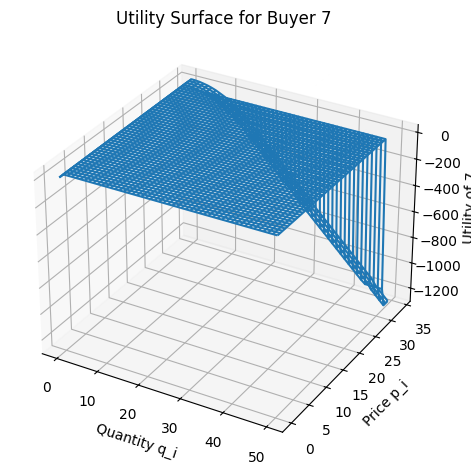

In [34]:

def do_conv(buyers_by_seller: Dict[Seller, List[Buyer]],
            max_rounds: int = 10,
            delay: float = 1.0):
    sellers = list(buyers_by_seller.keys())
    # collect each unique buyer exactly once
    all_buyers = []
    for blist in buyers_by_seller.values():
        for b in blist:
            if b not in all_buyers:
                all_buyers.append(b)

    for r in range(1, max_rounds+1):
      #changes = do_step(r, all_buyers)
      changes = 0
      # step each buyer exactly once (single‐auction or global)
      for b in all_buyers:
          if len(b.sellers) > 0:
              if b.global_step():
                changes += 1
          else:
              if b.step():
                  changes += 1
      if changes == 0:
          break
      time.sleep(delay)

    print_round(r, changes, buyers_by_seller, sellers)


def do_step(r: int, all_buyers: List[Buyer]):
      changes = 0
      # step each buyer exactly once (single‐auction or global)
      for b in all_buyers:
          if len(b.sellers) > 0:
              if b.global_step():
                changes += 1
          else:
              if b.step():
                  changes += 1
      print_round(r, changes, buyers_by_seller, sellers)
      return changes

def print_round(r: int,
                changes: int,
                buyers_by_seller: Dict[Seller, List[Buyer]],
                sellers: List[Seller]):
      print(f"--- Round {r} ---")
      print_round_multi(buyers_by_seller)
      print(f"Changes this round: {changes}\n")
      for l in sellers:
        market_totals(buyers_by_seller[l], l)
      if changes == 0:
          print("Convergence reached.")


if __name__ == "__main__":
    seller1 = Seller(1, Q_max=50.0, epsilon=5.0)
    seller2 = Seller(2, Q_max=50.0, epsilon=5.0)
    buyers1 = init_buyers(5, 0, [seller1])
    buyers2 = init_buyers(5, 5, [seller2])
    buyers3 = init_buyers(1, 10, [seller1, seller2])

    # Optional: save parameters
    #save_buyers_by_seller({seller1: buyers1, seller2: buyers2}, "buyers.csv")

    # Optional: load parameters
    #buyers_by_seller = load_buyers_by_seller("buyers.csv", [seller1, seller2])

    # Random initialization of bids
    #randbids(buyers, seller)

    # Plot valuations
    """
    plt.figure()
    for b in buyers:
        b.plot_valuation()
        plt.legend()
        plt.xlabel("Quantity z")
        plt.ylabel("Valuation θ_i(z)")
    """

    buyers_by_seller = {
        seller1: buyers1 + buyers3,
        seller2: buyers2 + buyers3,
    }
    print_buyers_multi(buyers_by_seller)
    #print_round_multi(buyers_by_seller)

    # Run the networked PSP auction across both sellers side-by-side
    do_conv(buyers_by_seller, max_rounds=1000, delay=0.5)

    # Plot utility surface (with s_-i)
    buyers2[2].plot_utility_surface(seller2.get_s_hat_minus(buyers2[2].i))